# Titanic Biclass AlexB

### Data understanding and intro

Import the different librairies i'll use in the notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier as Kne
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay

Read csv and asign it a variable df.

In [2]:
df = pd.read_csv("/Users/alexandrebredillot/Documents/GitHub/EXP/BICLASS - Titanic/Titanic-Dataset.csv")

Lets #1 get a better understanding of the data and the problem we can works toward solving.

In [3]:
pd.set_option('display.max_columns', None)
print(df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


The goal depicted by many works related to this dataset is to predict wether or not a passenger of Titanic survived based on the different profiles and the data provided. This is a binary classification problem and we will in this notebook delve into it.
The columns names are pretty consice and explicit (except for parch "parents and children present on board" and sibsp "siblings or spouse on board"), i won't change any.


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


The set is quite short, 891-entries but is enough for a pretty accurate prediction.


## Pipeline

### Data preparation

Now, I will start the pipeline of our models and predictions by cleaning the data and standardizing it.
Based on the different columns we can assume that certain features -such as the ticket number and cabin number aren't relevant enough to be included in our scope.

In [5]:
df = df.drop(columns = ["Ticket", "Cabin"])

Lets now try and standardize columns for wich we have Nan values.

In [6]:
null_cols = df.columns[df.isnull().any()]

print(df[null_cols].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       714 non-null    float64
 1   Embarked  889 non-null    object 
dtypes: float64(1), object(1)
memory usage: 14.1+ KB
None


By the looks of it, we found two passengers for wich we do not know the port of embarcation (maybe stowaways ?) and 177 passengers for wich we do not know the age.

     PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Fare Embarked  
61   female  38.0      0      0  80.0      nan  
829  female  62.0      0      0  80.0      nan  


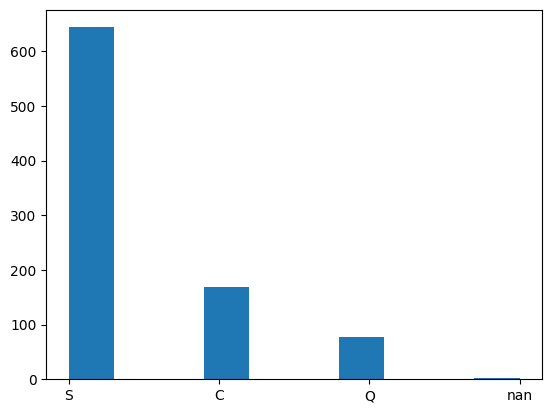

In [7]:
df["Embarked"] = df["Embarked"].astype(str)
plt.hist(df["Embarked"])
plt.show
print(df.loc[df["Embarked"] == "nan"])

Looking at the proporation of the different volumes of for each port of embarcation we will assume that 2 woman -wich aren't stowaways since we can see they both paid a fare of 80.00- embarked on S.

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

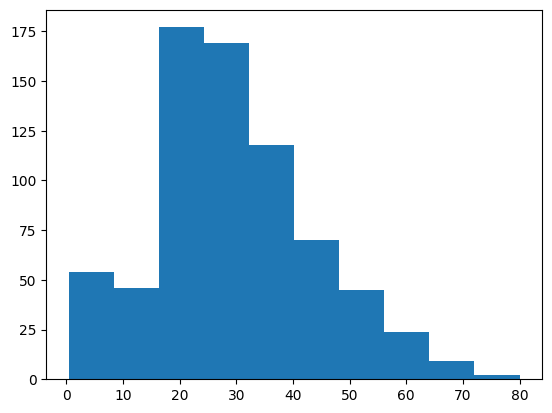

In [8]:
df["Embarked"] = df["Embarked"].replace("nan", "S")
plt.hist(df["Age"])
plt.show
df["Age"].describe()


Let's try using mean Age values for each titles in the Name col to reduce bias and fill-in the missing values.

In [9]:
df["Title"] = df["Name"].str.extract(r",\s*([^\.]+)\.")
print(df["Title"].value_counts())
print(df["Title"].value_counts().sum())


Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64
891


We'll bin the different titles so its easier to manipulate. 

In [10]:
titlemapping = {
    "Mr": "Mr",
    "Miss": "Miss",
    "Mrs": "Mrs",
    "Master": "Master",
    "Mlle": "Miss",
    "Ms": "Miss",
    "Mme": "Mrs",
    "the Countess": "Noble",
    "Lady": "Noble",
    "Sir": "Noble",
    "Don": "Noble",
    "Jonkheer": "Noble",
    "Dr" : "Professionnal", 
    "Capt" : "Professionnal",
    "Rev" : "Professionnal",
    "Major" : "Professionnal",
    "Col" : "Professionnal"
}

df["Titlebin"] = df["Title"].map(titlemapping)
mean_by_bin = df.groupby("Titlebin")["Age"].mean()
df.groupby("Titlebin")["Age"].describe()

,count,mean,std,min,25%,50%,75%,max
Titlebin,,,,,,,,
Master,36.0,4.574167,3.619872,0.42,1.0,3.5,8.0,12.0
Miss,149.0,21.845638,12.870542,0.75,14.5,21.0,30.0,63.0
Mr,398.0,32.368090,12.708793,11.00,23.0,30.0,39.0,80.0
Mrs,109.0,35.788991,11.437490,14.00,27.0,35.0,44.0,63.0
Noble,5.0,41.600000,6.804410,33.00,38.0,40.0,48.0,49.0
Professionnal,17.0,46.705882,12.819734,23.00,42.0,50.0,54.0,70.0


In [11]:
df["Age"] = df.apply(
    lambda row: mean_by_bin[row["Titlebin"]] if pd.isnull(row["Age"]) else row["Age"],
    axis=1
)

Nos valeurs dont l'âge n'était pas renseigné on maintenant un âge à priori plus proche de la réalité que si nous avions utilisé la moyenne globale. Révérifions l'état du df pour appliquer les derniers ajustements avant de passer à l'étape suivante.

In [12]:
print(df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch     Fare Embarked Title Titlebin  
0      0   7.2500        S    Mr       Mr  
1      0  71.2833        C   Mrs      Mrs  
2      0   7.9250        S  Miss     Miss  
3      0  53.1000        S   Mrs      Mrs  
4      0   8.0500        S    Mr       Mr  


Il reste à: 
- supprimer la colonne Name
- encoder les valeurs du Sex (mapping binaire) ainsi que celle de Embarked (one-hot avec sklearn)
- supprimer les colonnes de Titre

In [13]:
print(df["Embarked"])

0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, Length: 891, dtype: object


In [14]:
sexencodemapping = { "male" : 0 , "female" : 1}

df["SexP"] = df["Sex"].map(sexencodemapping)

encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded = encoder.fit_transform(df[["Embarked"]])

encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(["Embarked"]))

df = pd.concat([df.drop(["Embarked","Sex","Title","Titlebin","Name"], axis=1), encoded_df], axis=1)

print(df)

     PassengerId  Survived  Pclass        Age  SibSp  Parch     Fare  SexP  \
0              1         0       3  22.000000      1      0   7.2500     0   
1              2         1       1  38.000000      1      0  71.2833     1   
2              3         1       3  26.000000      0      0   7.9250     1   
3              4         1       1  35.000000      1      0  53.1000     1   
4              5         0       3  35.000000      0      0   8.0500     0   
..           ...       ...     ...        ...    ...    ...      ...   ...   
886          887         0       2  27.000000      0      0  13.0000     0   
887          888         1       1  19.000000      0      0  30.0000     1   
888          889         0       3  21.845638      1      2  23.4500     1   
889          890         1       1  26.000000      0      0  30.0000     0   
890          891         0       3  32.000000      0      0   7.7500     0   

     Embarked_Q  Embarked_S  
0           0.0         1.0  
1  

Now that we have a df pretty ready for model training and correlation matrix computation lets apply these calculations to the df.

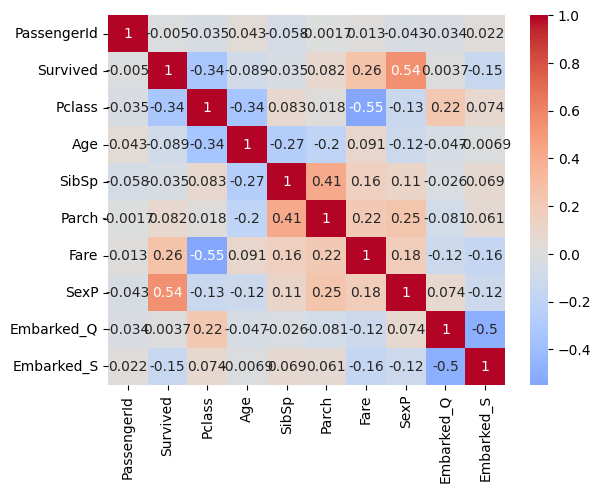

In [15]:
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.show()

Maintenant il ne nous reste plus qu'à séparer nos données en test et train plus charger les modèles et les entrainer.

In [16]:
X = df.drop("Survived", axis=1)
y = df["Survived"]


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state= 42,
    stratify=y
)

knn = neighbors.KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nMatrice de confusion:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6502242152466368

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.93      0.77       137
           1       0.65      0.20      0.30        86

    accuracy                           0.65       223
   macro avg       0.65      0.57      0.54       223
weighted avg       0.65      0.65      0.59       223


Matrice de confusion:
 [[128   9]
 [ 69  17]]


Tentons de comprendre les résultats pr adapter la démarches et améliorer la pipeline.

In [17]:
print("Comptes:\n", y.value_counts())
print("\nProportions:\n", y.value_counts(normalize=True).round(3))
imbalance_ratio = y.value_counts().min() / y.value_counts().max()
print("\nImbalance ratio:", round(imbalance_ratio, 3))

Comptes:
 Survived
0    549
1    342
Name: count, dtype: int64

Proportions:
 Survived
0    0.616
1    0.384
Name: proportion, dtype: float64

Imbalance ratio: 0.623
